# **Analyse dscriptive des données ratings IMDB 🍿📹**

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import ast

In [3]:
df_ratings_imdb=pd.read_csv('/Users/gustavetremey/Desktop/projet_python_films/projet_python_films/Data processing/IMDB_movie_ratings.csv')
df_ratings_imdb.head() #contrôle

,averageRating,numVotes,originalTitle,isAdult,release_year,runtimeMinutes,genres,director_name,primaryProfession
0,5.2,231,Miss Jerry,0,1894.0,45.0,Romance,Alexander Black,"director,writer,cinematographer"
1,5.3,578,The Corbett-Fitzsimmons Fight,0,1897.0,100.0,"Documentary,News,Sport",Enoch J. Rector,"director,cinematographer,editor"
2,6.0,1039,The Story of the Kelly Gang,0,1906.0,70.0,"Action,Adventure,Biography",Charles Tait,"director,writer"
3,4.8,36,L'enfant prodigue,0,1907.0,90.0,Drama,Michel Carré,"director,writer,actor"
4,5.2,73,The Life of Moses,0,1909.0,50.0,"Biography,Drama,Family",J. Stuart Blackton,"director,producer,miscellaneous"


On évalue l'état général du dataframe

In [74]:
df_ratings_imdb.describe()

,averageRating,numVotes,isAdult,release_year,runtimeMinutes
count,265654.000000,2.656540e+05,265654.000000,265654.000000,265654.000000
mean,6.137748,4.262008e+03,0.012806,1996.850110,94.819054
std,1.338916,4.012163e+04,0.112437,26.015858,157.845798
min,1.000000,5.000000e+00,0.000000,1894.000000,1.000000
25%,5.300000,2.500000e+01,0.000000,1980.000000,81.000000
50%,6.200000,8.800000e+01,0.000000,2007.000000,91.000000
75%,7.000000,4.350000e+02,0.000000,2017.000000,104.000000
max,10.000000,3.128869e+06,1.000000,2025.000000,59460.000000


In [4]:
df_ratings_imdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265654 entries, 0 to 265653
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   averageRating      265654 non-null  float64
 1   numVotes           265654 non-null  int64  
 2   originalTitle      265654 non-null  object 
 3   isAdult            265654 non-null  int64  
 4   release_year       265654 non-null  float64
 5   runtimeMinutes     265654 non-null  float64
 6   genres             265654 non-null  object 
 7   director_name      265654 non-null  object 
 8   primaryProfession  265654 non-null  object 
dtypes: float64(3), int64(2), object(4)
memory usage: 18.2+ MB


---

### Nombre d'avis

In [5]:
df_ratings_imdb['numVotes'].describe()

count    2.656540e+05
mean     4.262008e+03
std      4.012163e+04
min      5.000000e+00
25%      2.500000e+01
50%      8.800000e+01
75%      4.350000e+02
max      3.128869e+06
Name: numVotes, dtype: float64

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


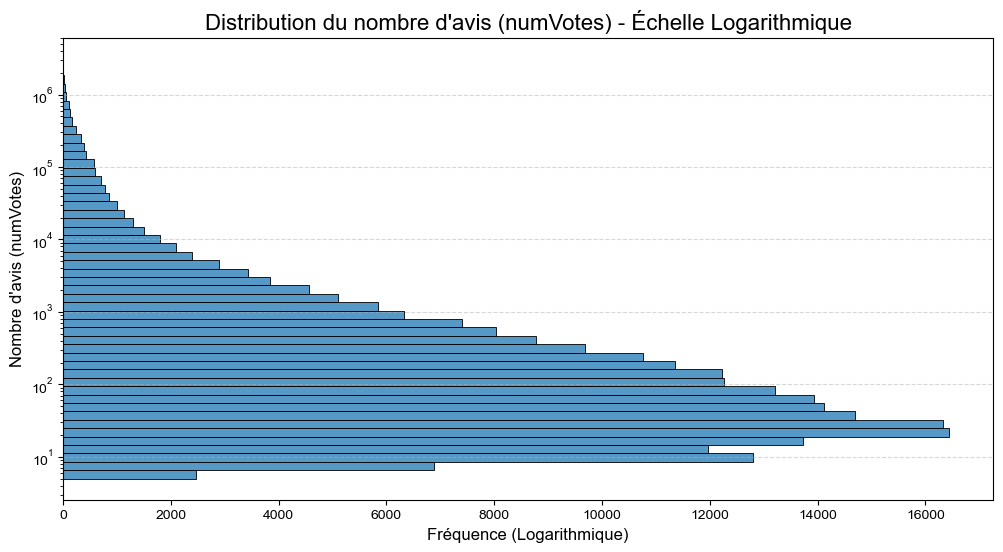

In [6]:
# Histogramme de la distribution du nombre de votes IMDB 
plt.figure(figsize=(12, 6))


sns.histplot(
    data=df_ratings_imdb,
    y='numVotes',
    bins=50,
    log_scale=(False, True)  #  Pour garder l'axe X (votes) linéaire et mettre l'axe Y (fréquence) en log
)

plt.title("Distribution du nombre d'avis (numVotes) - Échelle Logarithmique", fontsize=16)
plt.ylabel("Nombre d'avis (numVotes)", fontsize=12)
plt.xlabel("Fréquence (Logarithmique)", fontsize=12)
plt.grid(axis='y', alpha=0.5, linestyle='--')
plt.style.use('seaborn-v0_8')
plt.show()

*La distribution semble centrée vers 50, avec un décalage vers des films moins notés. On prend le parti de conserver tous ces films pour l'instant, afin de garder un groupe représentatif et divers. Le critère du nombre de votes n'est toutefois pas éliminé dans la sélection par la suite.*

*On teste sur les films à plus de 10 000 avis pour avoir une idée de la distribution sur des films de moyenne et plus grande ampleur*

In [7]:
mask = df_ratings_imdb['numVotes'] >= 10000
df_ratings_imdb_new=df_ratings_imdb.loc[mask]

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


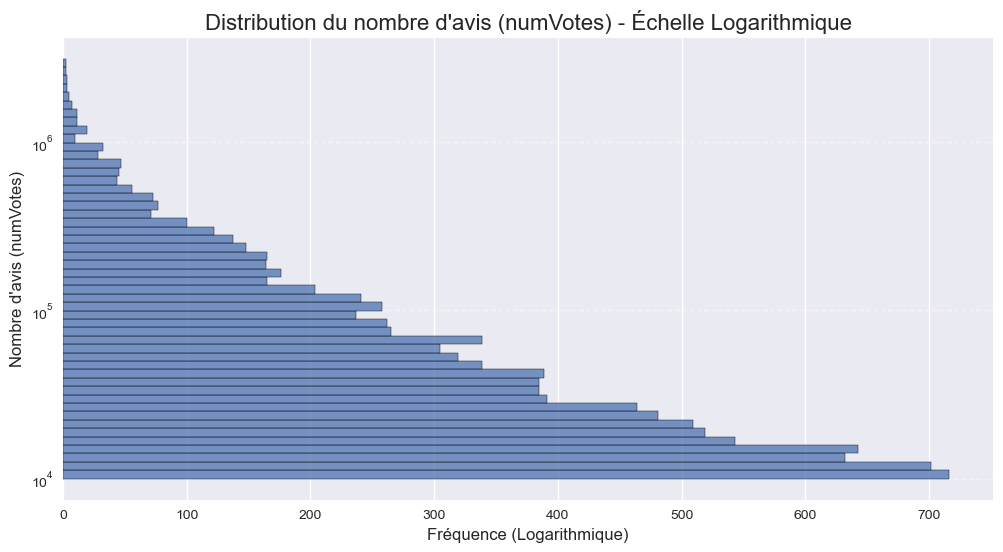

In [8]:
# Histogramme de la distribution du nombre de votes IMDB, supérieurs à 4000
plt.figure(figsize=(12, 6))

sns.histplot(
    data=df_ratings_imdb_new,
    y='numVotes',
    bins=50,
    log_scale=(False, True)  #  Pour garder l'axe X (votes) linéaire et mettre l'axe Y (fréquence) en log
)

plt.title("Distribution du nombre d'avis (numVotes) - Échelle Logarithmique", fontsize=16)
plt.ylabel("Nombre d'avis (numVotes)", fontsize=12)
plt.xlabel("Fréquence (Logarithmique)", fontsize=12)
plt.grid(axis='y', alpha=0.5, linestyle='--')
plt.style.use('seaborn-v0_8')
plt.show()

*Naturellement, il y a moins de films très connus que de films moins connus, la distribution est donc non centrée. On prend néanmoins le parti de la diversité en gardant des films relativement notés, dès 10 000 avis pour notre algorithme de recommandation.*

####

### Ratings

On évalue désormais la distribution des notes des films, entre 0 et 10

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


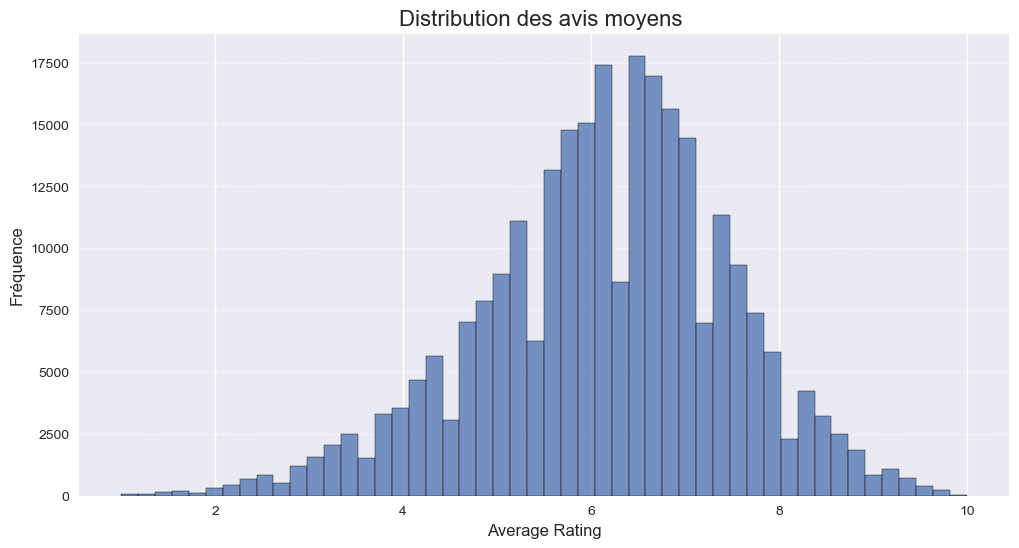

In [9]:
# Histogramme de la distribution du nombre d'avis moyens IMDB
plt.figure(figsize=(12, 6))


sns.histplot(
    data=df_ratings_imdb,
    x='averageRating',
    bins=50  )

plt.title("Distribution des avis moyens ", fontsize=16)
plt.xlabel("Average Rating", fontsize=12)
plt.ylabel("Fréquence", fontsize=12)
plt.grid(axis='y', alpha=0.5, linestyle='--')
plt.style.use('seaborn-v0_8')
plt.show()

### Genres

Un premier formattage est nécessaire pour placer les genres de films sous forme de liste et les séparer quand ils sont plusieurs, afin de pouvoir les quantifier correctement dans les analyses. Par exemple, ne pas sortir un genre Romance, Aventure mais distinguer les deux en même temps.

In [10]:
#Répartition des genres
df_ratings_imdb_genres=df_ratings_imdb.copy()
df_ratings_imdb_genres['genres']=df_ratings_imdb_genres['genres'].astype(str)
df_ratings_imdb_genres['genres']=df_ratings_imdb_genres['genres'].str.split(',')
df_ratings_imdb_genres=df_ratings_imdb_genres.explode('genres')
df_ratings_imdb_genres

,averageRating,numVotes,originalTitle,isAdult,release_year,runtimeMinutes,genres,director_name,primaryProfession
0,5.2,231,Miss Jerry,0,1894.0,45.0,Romance,Alexander Black,"director,writer,cinematographer"
1,5.3,578,The Corbett-Fitzsimmons Fight,0,1897.0,100.0,Documentary,Enoch J. Rector,"director,cinematographer,editor"
1,5.3,578,The Corbett-Fitzsimmons Fight,0,1897.0,100.0,News,Enoch J. Rector,"director,cinematographer,editor"
1,5.3,578,The Corbett-Fitzsimmons Fight,0,1897.0,100.0,Sport,Enoch J. Rector,"director,cinematographer,editor"
2,6.0,1039,The Story of the Kelly Gang,0,1906.0,70.0,Action,Charles Tait,"director,writer"
...,...,...,...,...,...,...,...,...,...
265651,6.4,6167,Akelarre,0,2020.0,92.0,Drama,Pablo Agüero,"director,writer,producer"
265651,6.4,6167,Akelarre,0,2020.0,92.0,History,Pablo Agüero,"director,writer,producer"
265651,6.4,6167,Akelarre,0,2020.0,92.0,Horror,Pablo Agüero,"director,writer,producer"
265652,7.6,12,Kuambil Lagi Hatiku,0,2019.0,123.0,Drama,Azhar Kinoi Lubis,"director,assistant_director,actor"


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


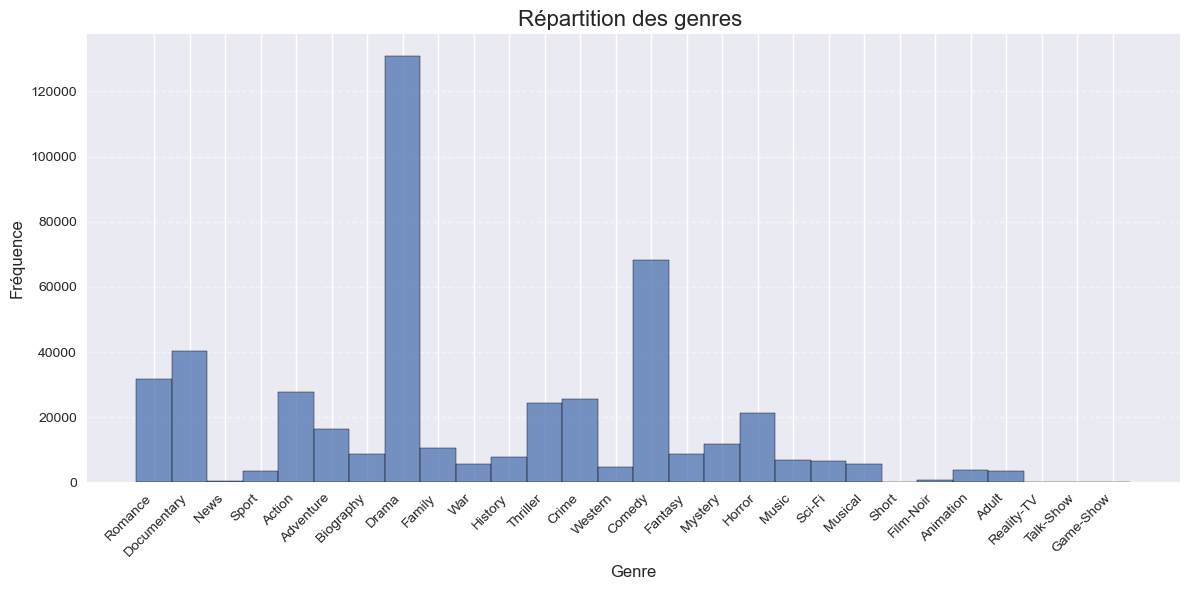

In [11]:
# Histogramme de la distribution des genres de films
plt.figure(figsize=(12, 6))


sns.histplot(
    data=df_ratings_imdb_genres,
    x='genres',
    bins=50  
)

plt.title("Répartition des genres ", fontsize=16)
plt.xlabel("Genre", fontsize=12)
plt.ylabel("Fréquence", fontsize=12)
plt.grid(axis='y', alpha=0.5, linestyle='--')
plt.xticks(rotation=45,ha='right')
plt.tight_layout()
plt.style.use('seaborn-v0_8')
plt.show()

*On observe une surreprésentation du genre drama et comedy, on les retire pour observer la distribution des autres catégories*

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


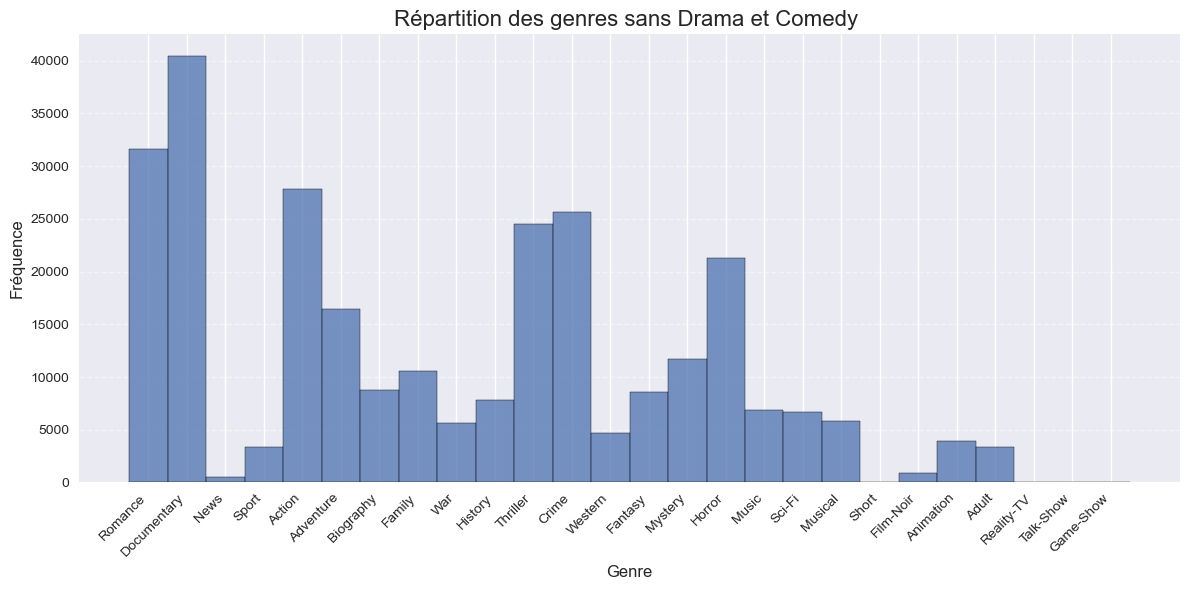

In [12]:
mask_genres = (df_ratings_imdb_genres['genres'] != 'Comedy') &(df_ratings_imdb_genres['genres'] != 'Drama')

# Histogramme de la distribution du nombre de votes IMDB 
plt.figure(figsize=(12, 6))


sns.histplot(
    data=df_ratings_imdb_genres[mask_genres],
    x='genres',
    bins=50  #  Pour garder l'axe X (votes) linéaire et mettre l'axe Y (fréquence) en log
)

plt.title("Répartition des genres sans Drama et Comedy ", fontsize=16)
plt.xlabel("Genre", fontsize=12)
plt.ylabel("Fréquence", fontsize=12)
plt.grid(axis='y', alpha=0.5, linestyle='--')
plt.xticks(rotation=45,ha='right')
plt.tight_layout()
plt.style.use('seaborn-v0_8')
plt.show()

*Certains genres prédominent clairement, on remarque surtout de faibles valeurs au niveau de news, talk show, game-show, short et film noir. Ces genres restent marginaux dans notre but de recommandation de films. Leur proportion empirique ne semble pas anormale non plus.*

##### 

### Réalisateurs

In [35]:
## Classement des réalisateurs avec plus de 20 films dans le dataset
df_ratings_imdb_directors = df_ratings_imdb.copy()
df_ratings_imdb_directors['director_name'] = df_ratings_imdb_directors['director_name'].astype(str)
df_ratings_imdb_directors['director_name'] = df_ratings_imdb_directors['director_name'].str.split(',')
df_ratings_imdb_directors = df_ratings_imdb_directors.explode('director_name')
df_ratings_imdb_directors

# compter les films par réalisateur (index = nom du réalisateur)
director_counts = df_ratings_imdb_directors['director_name'].value_counts()

# sélection des réalisateurs ayant >= 20 films (Index de noms)
mask_20_films = director_counts >= 20
directors_20_films = director_counts[mask_20_films].index

# (optionnel) DataFrame contenant uniquement les lignes des réalisateurs avec >= 20 films
df_directors_20_films = df_ratings_imdb_directors[df_ratings_imdb_directors['director_name'].isin(directors_20_films)]
df_directors_20_films=df_directors_20_films.groupby('director_name').agg(moyenne_numVotes=('numVotes', 'mean'),
                                                  moyenne_Rating=('averageRating', 'mean'))

df_directors_20_films=pd.merge(df_directors_20_films,director_counts, on='director_name',how='left')

df_directors_20_films


,moyenne_numVotes,moyenne_Rating,count
director_name,,,
A. Bhimsingh,106.840000,7.036000,25
A. Edward Sutherland,610.767442,5.900000,43
A. Kodandarami Reddy,163.395349,6.862791,43
A. Razak Mohaideen,69.390244,5.102439,41
Aarne Tarkas,105.000000,5.574194,31
...,...,...,...
Çetin Inanç,256.066667,5.064444,45
Édouard Molinaro,1515.272727,6.160606,33
Éric Rohmer,6168.240000,7.144000,25


In [36]:
df_directors_20_films_famous=df_directors_20_films.copy()
df_directors_20_films_famous=df_directors_20_films_famous.loc[df_directors_20_films_famous['moyenne_numVotes']>10000]
df_directors_20_films_famous

,moyenne_numVotes,moyenne_Rating,count
director_name,,,
Akira Kurosawa,50570.214286,7.553571,28
Alfred Hitchcock,79434.566038,6.883019,53
Barry Levinson,63295.851852,6.385185,27
Billy Wilder,62358.600000,7.448000,25
Blake Edwards,16976.078947,6.289474,38
...,...,...,...
William Wyler,17330.804348,6.769565,46
Wilson Yip,22151.956522,6.152174,23
Wim Wenders,16209.387097,6.687097,31


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


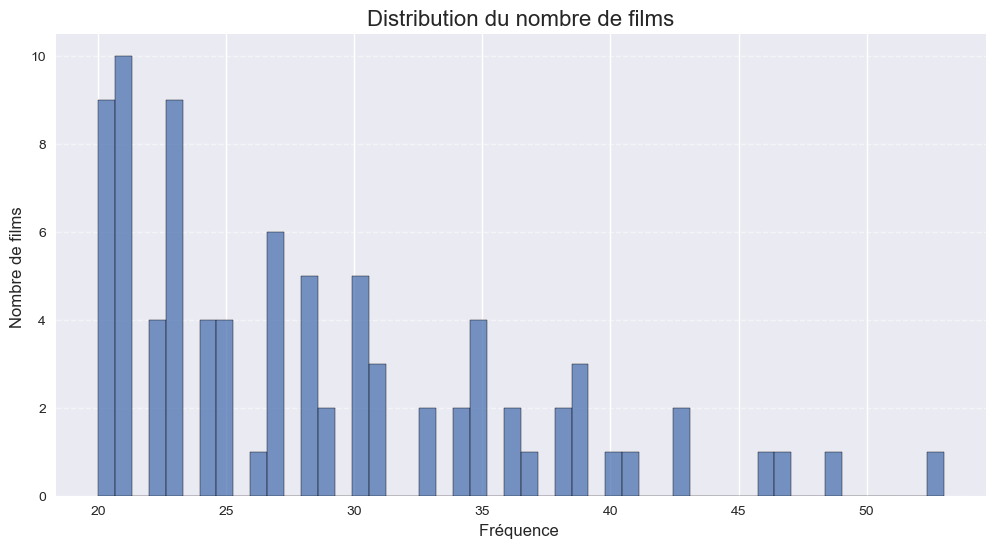

In [43]:
# Histogramme de la distribution des films par réalisateur (avec plus de 20 films et plus de 10 000 votes moyens)
plt.figure(figsize=(12, 6))


sns.histplot(
    data=df_directors_20_films_famous,
    x='count',
    bins=50,
      #  Pour garder l'axe X (votes) linéaire et mettre l'axe Y (fréquence) en log
)

plt.title("Distribution du nombre de films", fontsize=16)
plt.ylabel("Nombre de films ", fontsize=12)
plt.xlabel("Fréquence ", fontsize=12)
plt.grid(axis='y', alpha=0.5, linestyle='--')
plt.style.use('seaborn-v0_8')
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


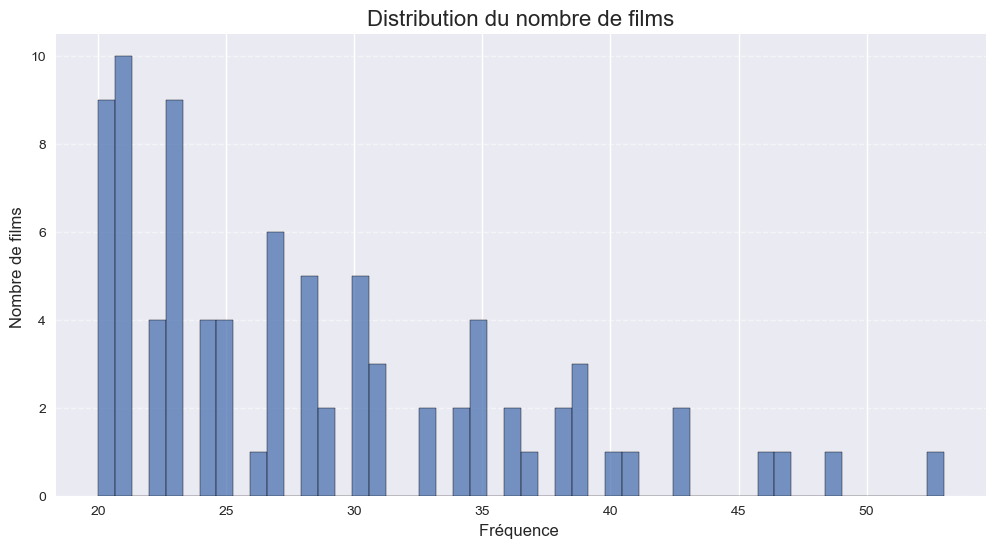

In [55]:
# Histogramme de la distribution des films par réalisateur (avec plus de 20 films et plus de 10 000 votes moyens)
plt.figure(figsize=(12, 6))


sns.histplot(
    data=df_directors_20_films_famous,
    x='count',
    bins=50,
      #  Pour garder l'axe X (votes) linéaire et mettre l'axe Y (fréquence) en log
)

plt.title("Distribution du nombre de films", fontsize=16)
plt.ylabel("Nombre de films ", fontsize=12)
plt.xlabel("Fréquence ", fontsize=12)
plt.grid(axis='y', alpha=0.5, linestyle='--')
plt.style.use('seaborn-v0_8')
plt.show()

### Années de sortie

In [ ]:
df_ratings_imdb['release_year'].describe()

count    265654.000000
mean       1996.850110
std          26.015858
min        1894.000000
25%        1980.000000
50%        2007.000000
75%        2017.000000
max        2025.000000
Name: release_year, dtype: float64

Pour des films débutant en 1894 dans le dataframe, on remarque une distribution bien plus concentrée sur les 20-30 dernières années observées. L'essor de la production cinématographique justifie particulièrement cette concentration récente.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


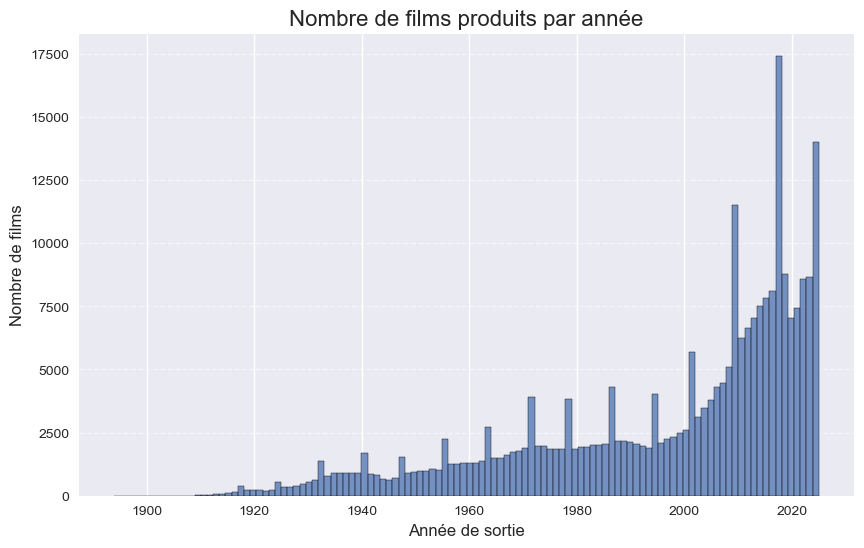

In [ ]:
plt.figure(figsize=(10,6))


sns.histplot(
    data=df_ratings_imdb,
    x='release_year'
)

plt.xlabel("Année de sortie", fontsize=12)
plt.ylabel("Nombre de films", fontsize=12)
plt.title("Nombre de films produits par année", fontsize=16)
plt.grid(axis='y', alpha=0.5, linestyle='--')
plt.style.use('seaborn-v0_8')
plt.show()

On se concentre ici brièvement sur l'intervalle de temps 1990-2025 pour observer des valeurs particulières.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


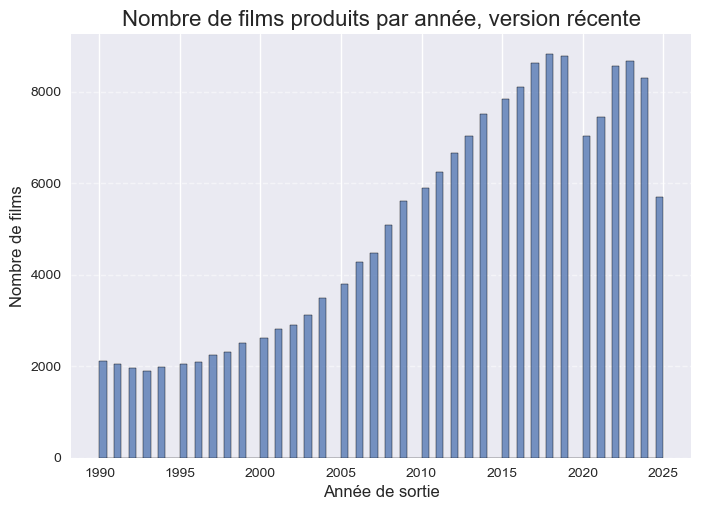

In [73]:
recent_movies=df_ratings_imdb['release_year']>=1990

df_recent_movies=df_ratings_imdb[recent_movies]

sns.histplot(
    data=df_recent_movies,
    x='release_year'
)

plt.xlabel("Année de sortie", fontsize=12)
plt.ylabel("Nombre de films", fontsize=12)
plt.title("Nombre de films produits par année, version récente", fontsize=16)
plt.grid(axis='y', alpha=0.5, linestyle='--')
plt.style.use('seaborn-v0_8')
plt.show()